<a href="https://www.kaggle.com/code/krippanandhini/apple-quality-classification-with-98-roc-auc-score?scriptVersionId=167083065" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier,ExtraTreesClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc

from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

2024-03-15 03:36:13.000715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 03:36:13.000889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 03:36:13.159047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reading the dataset

In [2]:
df = pd.read_csv('/kaggle/input/apple-quality/apple_quality.csv')
df.head()

A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4   4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

        Acidity Quality  
0  -0.491590483    good  
1  -0.722809367    good  
2   2.621636473     bad  
3   0.790723217    good  
4   0.501984036    good

## Data cleaning

In [3]:
df.shape

(4001, 9)

In [4]:
df.drop('A_id', axis = 1, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4001 non-null   object 
 7   Quality      4000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 250.2+ KB


In [6]:
df.isna().sum()

Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

In [7]:
df['Acidity'].unique()

array(['-0.491590483', '-0.722809367', '2.621636473', ..., '-2.229719806',
       '1.599796456', 'Created_by_Nidula_Elgiriyewithana'], dtype=object)

In [8]:
df = df[df['Acidity'] != 'Created_by_Nidula_Elgiriyewithana']

In [9]:
df['Acidity'] = df['Acidity'].astype(float)

In [10]:
df.isna().sum()

Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

## EDA

In [11]:
df.describe()

Size       Weight    Sweetness  Crunchiness    Juiciness  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     -0.503015    -0.989547    -0.470479     0.985478     0.512118   
std       1.928059     1.602507     1.943441     1.402757     1.930286   
min      -7.151703    -7.149848    -6.894485    -6.055058    -5.961897   
25%      -1.816765    -2.011770    -1.738425     0.062764    -0.801286   
50%      -0.513703    -0.984736    -0.504758     0.998249     0.534219   
75%       0.805526     0.030976     0.801922     1.894234     1.835976   
max       6.406367     5.790714     6.374916     7.619852     7.364403   

          Ripeness      Acidity  
count  4000.000000  4000.000000  
mean      0.498277     0.076877  
std       1.874427     2.110270  
min      -5.864599    -7.010538  
25%      -0.771677    -1.377424  
50%       0.503445     0.022609  
75%       1.766212     1.510493  
max       7.237837     7.404736

In [12]:
df['Quality'].value_counts()

Quality
good    2004
bad     1996
Name: count, dtype: int64

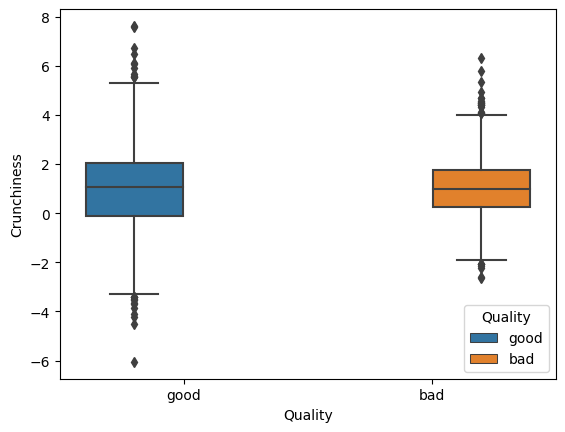

In [13]:
sns.boxplot(x = "Quality", y = "Crunchiness", hue = "Quality", data = df)
plt.show()

In [14]:
px.scatter(data_frame = df, x = 'Sweetness', y = 'Acidity')

## Machine Learning

In [15]:
le = LabelEncoder()
df['Quality'] = le.fit_transform(df['Quality'])

### Correlation matrix

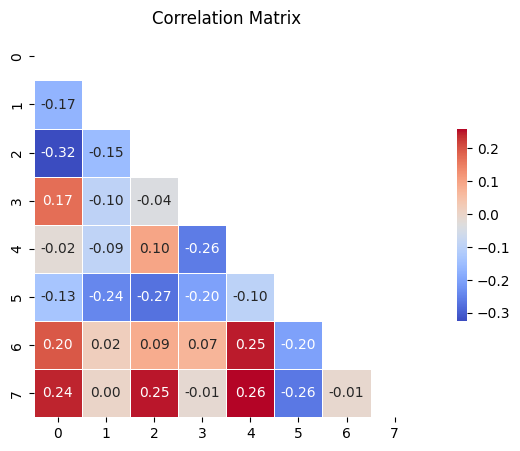

In [16]:
# Calculate correlation matrix
corr_matrix = np.corrcoef(df, rowvar=False)

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,mask = mask,annot=True,cmap = "coolwarm", fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

In [17]:
X = df.drop('Quality', axis=1)
y = df['Quality']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Decision tree with Adaboost

In [20]:
tree_clf = DecisionTreeClassifier(max_depth=12)

In [21]:
ada_clf = AdaBoostClassifier(estimator=tree_clf, n_estimators=75, learning_rate=0.75, random_state=42)
scores = cross_val_score(ada_clf, X, y, cv=5)

In [22]:
print("Cross-validation scores:", scores)

Cross-validation scores: [0.9125  0.89875 0.895   0.89375 0.9075 ]


In [23]:
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Mean accuracy: 0.9014999999999999
Standard deviation: 0.007305819598101201


### Decision Tree classifier

In [24]:
dt_clf = DecisionTreeClassifier(max_depth = 12)
scores_dt = cross_val_score(dt_clf, X, y, cv=5)

In [25]:
print("Scores:", scores_dt)
print("Mean accuracy:", scores_dt.mean())

Scores: [0.78875 0.83375 0.8275  0.81375 0.79875]
Mean accuracy: 0.8125


### Support Vector Machine Classifier

In [26]:
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X, y, cv=5)

In [27]:
print("Support Vector Classifier (SVC) cross-validation scores:", svc_scores)
print("Mean accuracy:", svc_scores.mean())

Support Vector Classifier (SVC) cross-validation scores: [0.89375 0.89125 0.88375 0.88    0.8975 ]
Mean accuracy: 0.88925


### Logistic regression

In [28]:
log_reg_clf = LogisticRegression()
log_reg_scores = cross_val_score(log_reg_clf, X, y, cv=5)

In [29]:
print("Logistic Regression cross-validation scores:", log_reg_scores)
print("Mean accuracy:", log_reg_scores.mean())

Logistic Regression cross-validation scores: [0.78    0.72375 0.75625 0.74375 0.73625]
Mean accuracy: 0.748


### Naive bayes

In [30]:
nb_clf = GaussianNB()
nb_scores = cross_val_score(nb_clf, X, y, cv=5)

In [31]:
print("Naive Bayes Classifier cross-validation scores:", nb_scores)
print("Mean accuracy:", nb_scores.mean())

Naive Bayes Classifier cross-validation scores: [0.745   0.74375 0.75625 0.7475  0.74625]
Mean accuracy: 0.74775


### XG Boost classifier

In [32]:
xgb_clf = xgb.XGBClassifier()
xgb_scores = cross_val_score(xgb_clf, X, y, cv=5)

In [33]:
print("XGBoost cross-validation scores:", xgb_scores)
print("Mean accuracy:", xgb_scores.mean())

XGBoost cross-validation scores: [0.8925 0.885  0.89   0.885  0.885 ]
Mean accuracy: 0.8875


### Bagging classifier

In [34]:
bagging_clf = BaggingClassifier()
bagging_scores = cross_val_score(bagging_clf, X, y, cv=5)

In [35]:
print("Bagging Classifier cross-validation scores:", bagging_scores)
print("Mean accuracy:", bagging_scores.mean())

Bagging Classifier cross-validation scores: [0.865   0.85125 0.875   0.8575  0.85125]
Mean accuracy: 0.86


### Ridge classifier

In [36]:

ridge_clf = RidgeClassifier()
ridge_scores = cross_val_score(ridge_clf, X, y, cv=5)

In [37]:
print("Ridge Classifier cross-validation scores:", ridge_scores)
print("Mean accuracy:", ridge_scores.mean())

Ridge Classifier cross-validation scores: [0.78    0.7225  0.7625  0.74125 0.7325 ]
Mean accuracy: 0.7477499999999999


### Gradient Boosting Classifier

In [38]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_scores = cross_val_score(gb_clf, X, y, cv=5)

In [39]:
print("Gradient Boosting Classifier cross-validation scores:", gb_scores)
print("Mean accuracy:", gb_scores.mean())
print("Standard deviation:", gb_scores.std())

Gradient Boosting Classifier cross-validation scores: [0.86125 0.8525  0.865   0.8425  0.8625 ]
Mean accuracy: 0.8567500000000001
Standard deviation: 0.008276472678623413


### Catboost classifier

In [40]:
catboost_clf = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=0)
cb_scores = cross_val_score(catboost_clf, X, y, cv=5)

In [41]:
print("CatBoost Classifier cross-validation scores:", cb_scores)
print("Mean accuracy:", cb_scores.mean())
print("Standard deviation:", cb_scores.std())

CatBoost Classifier cross-validation scores: [0.89    0.87375 0.8625  0.8775  0.885  ]
Mean accuracy: 0.87775
Standard deviation: 0.00949999999999999


### Random forest classifier

In [42]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_clf, X, y, cv=5)

In [43]:
print("Random Forest Classifier cross-validation scores:", rf_scores)
print("Mean accuracy:", rf_scores.mean())

Random Forest Classifier cross-validation scores: [0.89    0.87125 0.89    0.88125 0.88375]
Mean accuracy: 0.88325


### K Nearest Neighbours

In [44]:
k =  7 
knn = KNeighborsClassifier(n_neighbors=k)
# Cross-validation
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
knn.fit(X_train, y_train)

# Predictions on the testing set
y_pred = knn.predict(X_test)

In [45]:
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.878125  0.896875  0.9015625 0.890625  0.8921875]
Mean CV accuracy: 0.8918750000000001


### LightGBM classifier

In [46]:
lgbm_clf = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Perform cross-validation
lgb_scores = cross_val_score(lgbm_clf, X, y, cv=5)

[LightGBM] [Info] Number of positive: 1603, number of negative: 1597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500938 -> initscore=0.003750
[LightGBM] [Info] Start training from score 0.003750
[LightGBM] [Info] Number of positive: 1603, number of negative: 1597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500938 -> initscore=0.003750
[LightGBM] [Info] Start training from score 0.003750
[LightGBM] [Info] Number

In [47]:
print("LightGBM Classifier cross-validation scores:", lgb_scores)
print("Mean accuracy:", lgb_scores.mean())

LightGBM Classifier cross-validation scores: [0.88625 0.88    0.8925  0.895   0.88875]
Mean accuracy: 0.8885


### Extra trees classifier

In [48]:
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_trees_scores = cross_val_score(extra_trees_clf, X, y, cv=5)

In [49]:
print("ExtraTrees Classifier cross-validation scores:", extra_trees_scores)
print("Mean accuracy:", extra_trees_scores.mean())

ExtraTrees Classifier cross-validation scores: [0.8925  0.875   0.8975  0.88625 0.9025 ]
Mean accuracy: 0.89075


### QDA

In [50]:
qda_clf = QuadraticDiscriminantAnalysis()
qda_scores = cross_val_score(qda_clf, X, y, cv=5)

In [51]:
print("Quadratic Discriminant Analysis (QDA) cross-validation scores:", qda_scores)
print("Mean accuracy:", qda_scores.mean())

Quadratic Discriminant Analysis (QDA) cross-validation scores: [0.865   0.845   0.85    0.84375 0.85   ]
Mean accuracy: 0.85075


### LDA

In [52]:
lda_clf = LinearDiscriminantAnalysis()
lda_scores = cross_val_score(lda_clf, X, y, cv=5)

In [53]:
print("Linear Discriminant Analysis (LDA) cross-validation scores:", lda_scores)
print("Mean accuracy:", lda_scores.mean())

Linear Discriminant Analysis (LDA) cross-validation scores: [0.78    0.7225  0.7625  0.74125 0.7325 ]
Mean accuracy: 0.7477499999999999


## Deep Learning

### Multi Layer Perceptron

In [54]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), learning_rate_init=0.075, random_state=42)

In [55]:
scores = cross_val_score(mlp_clf, X, y, cv=5) 

In [56]:
print("MLP Classifier cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

MLP Classifier cross-validation scores: [0.93    0.9425  0.925   0.92375 0.9375 ]
Mean accuracy: 0.9317500000000001


## Neural Networks

In [57]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a function to create the neural network model
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim = X.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Initialize lists to store accuracy scores
accuracy_scores = []

# Iterate through each fold of cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create the neural network model
    model = create_model()
    
    # Fit the model on the training data
    model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)
    
    # Evaluate the model on the test data
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Store the accuracy score
    accuracy_scores.append(accuracy)

In [58]:
accuracy_scores = np.array(accuracy_scores)

print("Neural Network Classifier cross-validation scores:", accuracy_scores)
print("Mean accuracy:", round(accuracy_scores.mean(),2))

Neural Network Classifier cross-validation scores: [0.95375001 0.94125003 0.94375002 0.94       0.92624998]
Mean accuracy: 0.94


The best model is Neural networks.

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


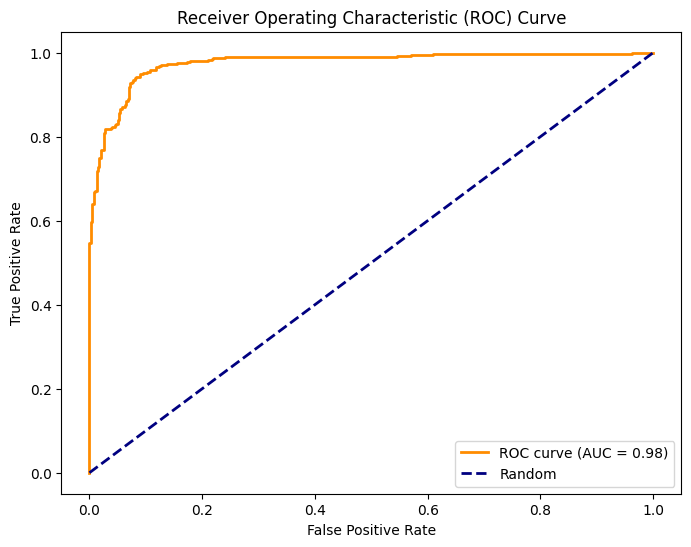

In [59]:
y_prob = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Please upvote, if you find this insightful. Thank you